# Data Analysis

In this phase, we check the integrity of the data.

In [1]:
import pandas as pd
from data.paths import TabularDataPaths
import  matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## What's the interesting thing we can see from the data?
## [x] (1) What's the most focused point in the model? (DID)
## [x] (2) What's the average time? Time distribution according to the diagnostic result (DID)
## [ ] (3) Is there any relationship btw diagnosis and gender? => If it is, it means the gender can be a meaningful data to input into our model
## [ ] (4) trying to find out the relationship btw the clinical data and the diagnosis.

In [3]:
# Refactor the loader into .py.
# load the meatdata about the MIMIC cxr

cxr_meta_df = pd.read_csv("D:\XAMI-MIMIC\spreadsheets\cxr_meta.csv")
cxr_meta_with_stay_id_df = pd.read_csv("D:\XAMI-MIMIC\spreadsheets\cxr_meta_with_stay_id_only.csv")


# Do analysis with the CXR-JPG dataset with CheXpert lables.

In [4]:
cxr_chexpert_df = pd.read_csv("D:\XAMI-MIMIC\spreadsheets\CXR-JPG\cxr_chexpert.csv")
cxr_chexpert_df.head(5)

,Unnamed: 0,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


In [5]:
## so we must have the study_id to track the subject of stay and something else.
## Let's do patients data first
core_patients_df = pd.read_csv("D:\mimic-iv-1.0\mimic-iv-1.0\core\patients.csv")
core_patients_df.head(5)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000048,F,23,2126,2008 - 2010,NaN
1,10002723,F,0,2128,2017 - 2019,NaN
2,10003939,M,0,2184,2008 - 2010,NaN
3,10004222,M,0,2161,2014 - 2016,NaN
4,10005325,F,0,2154,2011 - 2013,NaN


In [6]:
## Checking if the Core_patients table has contain all the patients in the CheXpert.
all_patients_in_core = list(core_patients_df['subject_id'])

patients_in = cxr_chexpert_df['subject_id'].isin(all_patients_in_core)
patients_not_in = [not p_id for p_id in patients_in]

In [7]:
print(f"{len(cxr_chexpert_df[patients_not_in])} of {len(cxr_chexpert_df)} instance cannot find corresponded patients in the Core_patients datatable, it can be caused by the version unmatching problem.")

# stay_id in MIMIC-IV v1.0 are not compatible with stay_id from v0.4. We do not intend to change stay_id when updating MIMIC-IV, but had to update it due to the error identified above.
# the 0.4 version of the MIMIC-ED is no longer available, so we can't even downgrade it to 0.4 directly.


527 of 227827 instance cannot find corresponded patients in the Core_patients datatable, it can be caused by the version unmatching problem.


In [8]:
## In the below section, we will use the patients inside Core_patients only
cxr_chexpert_df = cxr_chexpert_df[patients_in]
print(f"If we remove the instances that can't find its patient_id in Core_paitients table, we will still have {len(cxr_chexpert_df)} instances.")


If we remove the instances that can't find its patient_id in Core_paitients table, we will still have 227300 instances.


In [9]:
# We add gender and other features in the Core_patieents to cxr_chexpert
# for col in [ col for col in core_patients_df.columns if col != "subject_id"]:
#     cxr_chexpert_df[col]  = cxr_chexpert_df['subject_id'].apply(lambda id: core_patients_df.iloc[core_patients_df['subject_id'].eq(id).idxmin()][col])

In [10]:
merged_df = pd.merge(cxr_chexpert_df, core_patients_df, how="left", on="subject_id", suffixes=("", ""))

In [11]:
merged_df.head(5)

,Unnamed: 0,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,...,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,gender,anchor_age,anchor_year,anchor_year_group,dod
0,0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,52,2180,2014 - 2016,NaN
1,1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,52,2180,2014 - 2016,NaN
2,2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,52,2180,2014 - 2016,NaN
3,3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F,52,2180,2014 - 2016,NaN
4,4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.0,NaN,NaN,M,86,2132,2014 - 2016,NaN


In [12]:
# we have to identify the diseases columns and update them to boolean.
disease_columns = ['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']

In [13]:
# for col in disease_columns:
#     merged_df[col] = merged_df[col].eq(1)

In [14]:
cxr_chexpert_df.head(5)

,Unnamed: 0,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


In [15]:
merged_df['Lung Opacity'].value_counts()

 1.0    51429
-1.0     3825
 0.0     3062
Name: Lung Opacity, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

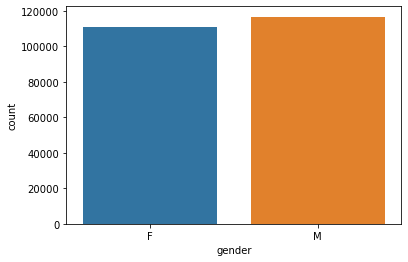

In [16]:
sns.countplot(x="gender", data=merged_df)

<AxesSubplot:xlabel='Atelectasis', ylabel='count'>

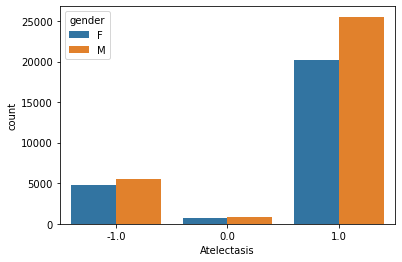

In [17]:
sns.countplot(x="Atelectasis", data=merged_df,  hue="gender")

<AxesSubplot:xlabel='Lung Lesion', ylabel='count'>

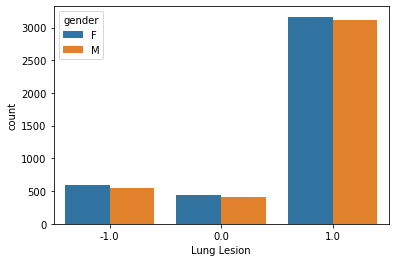

In [18]:
sns.countplot(x="Lung Lesion", data=merged_df,  hue="gender")


In [20]:
cxr_meta_df.head(5)

,Unnamed: 0,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,in_eye_gaze,in_reflacx,StudyDateTime,stay_id
0,177,fa771fa1-d9571d07-bff8f655-327734a7-6e10b29d,10002428,59258773,CHEST (PORTABLE AP),AP,3056,2544,21560419,92717.109,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.156042e+12,NaN
1,181,4873aa08-977bfd31-fb492e64-6ef432d1-3f12cbe3,10002430,53254222,CHEST (PA AND LAT),PA,3056,2544,21250928,160736.171,CHEST (PA AND LAT),postero-anterior,Erect,True,False,2.125093e+13,31293660.0
2,266,dcdc4bd9-4301b111-2a65a814-ee8e7bc5-7f0b9a5a,10003400,56466802,CHEST (PORTABLE AP),AP,3056,2544,21361209,133738.015,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.136121e+13,33678912.0
3,497,5bdabba9-388f6646-ac06b5f5-f68b2fd2-3630de21,10011607,55814288,CHEST (PA AND LAT),AP,3056,2544,21820111,230933.250,CHEST (PA AND LAT),antero-posterior,Erect,False,True,2.182011e+13,37054412.0
4,539,4a629500-9c3281ca-90bab490-9b6ac9c1-e5e6a580,10012261,53728467,CHEST (PORTABLE AP),AP,2544,3056,21750906,191151.453,CHEST (PORTABLE AP),antero-posterior,Erect,False,True,2.175091e+13,38668412.0
